In [141]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
import pyspark.sql.functions as F

# Create a Spark session
spark = SparkSession.builder \
    .appName("MySparkApp") \
    .getOrCreate()

# Check if SparkSession is created successfully
print(spark)

In [142]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [143]:
file_path = 'data/DataCoSupplyChainDataset.csv'
df = spark.read.csv(file_path, header=True, inferSchema=True)
# Some house cleaning where the the column names are standardized

for col in df.columns:
    new_col = col.replace(' ', '_').lower()
    df = df.withColumnRenamed(col, new_col)

df = df.withColumn("order_date", F.to_date(F.date_format(F.unix_timestamp("order_date_(dateorders)", "M/d/yyyy H:mm").cast("timestamp"), "yyyy-MM-dd")))
df = df.withColumn("shipping_date", F.to_date(F.date_format(F.unix_timestamp("shipping_date_(dateorders)", "M/d/yyyy H:mm").cast("timestamp"), "yyyy-MM-dd")))
df = df.withColumnRenamed('days_for_shipping_(real)', 'actual_time')
df = df.withColumnRenamed('days_for_shipment_(scheduled)', 'predicted_time')

In [144]:
from pyspark.sql.functions import year, month, dayofmonth
df = df.withColumn("o_year", year(df["order_date"])) \
       .withColumn("o_month", month(df["order_date"])) \
       .withColumn("o_day", dayofmonth(df["order_date"]))

df = df.withColumn("s_year", year(df["shipping_date"])) \
       .withColumn("s_month", month(df["shipping_date"])) \
       .withColumn("s_day", dayofmonth(df["shipping_date"]))

In [145]:
df = df.drop('product_image', 'customer_password', 'customer_email', 
             'customer_fname', 'customer_lname', 'customer_street', 
             'latitude', 'longitude', 'product_description',
             "order_date_(dateorders)", "shipping_date_(dateorders)",
             'days_for_shipment_(scheduled)', 'days_for_shipping_(real)')    
df.createOrReplaceTempView("my_table")
df.show(5)

+--------+-----------+--------------+-----------------+------------------+----------------+------------------+-----------+--------------+-------------+----------------+-----------+----------------+--------------+----------------+-------------+---------------+------------+----------+-------------+-----------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+---------------+---------------+-------------+---------------+-------------------+------------+-------------+--------------+--------------+----------+-------------+------+-------+-----+------+-------+-----+
|    type|actual_time|predicted_time|benefit_per_order|sales_per_customer| delivery_status|late_delivery_risk|category_id| category_name|customer_city|customer_country|customer_id|customer_segment|customer_state|customer_zipcode|department_id|department_na

In [153]:
product_list = spark.sql("""Select
          product_name, product_card_id,
          sum(order_item_quantity) as quantity
          from my_table
          group by product_name, product_card_id
          order by quantity desc
          """).toPandas()
product_list

,product_name,product_card_id,quantity
0,Perfect Fitness Perfect Rip Deck,365,73698
1,Nike Men's Dri-FIT Victory Golf Polo,502,62956
2,O'Brien Men's Neoprene Life Vest,1014,57803
3,Nike Men's Free 5.0+ Running Shoe,191,36680
4,Under Armour Girls' Toddler Spine Surge Runni,627,31735
...,...,...,...
113,Stiga Master Series ST3100 Competition Indoor,127,27
114,SOLE E35 Elliptical,208,15
115,Bushnell Pro X7 Jolt Slope Rangefinder,860,11
116,SOLE E25 Elliptical,60,10


Setting up the tables/views necessary for the forecasting

In [187]:
prophet_df = spark.sql("""
                       Select order_date as ds,
                       sum(order_item_quantity) as y
                       From my_table
                       Where product_card_id = 191
                       AND o_year < 2017 
                       group by ds
                       order by ds
                       """)
prophet_df.show(5)
prophet_df = prophet_df.toPandas()

+----------+---+
|        ds|  y|
+----------+---+
|2015-01-01| 28|
|2015-01-02| 29|
|2015-01-03| 59|
|2015-01-04| 44|
|2015-01-05| 38|
+----------+---+
only showing top 5 rows



In [148]:
spark.sql("""
            CREATE OR REPLACE TEMPORARY VIEW actual AS
            Select order_date as ds,
            sum(order_item_quantity) as y
            From my_table
            Where product_card_id = 191
            AND o_year Between 2017 and 2018
            group by ds
            order by ds
        """)
# actual.show(5)
# spark.sql('select * from actual').show(5)

+----------+---+
|        ds|  y|
+----------+---+
|2017-01-01| 44|
|2017-01-02| 45|
|2017-01-03| 24|
|2017-01-04| 41|
|2017-01-05| 40|
|2017-01-06| 44|
|2017-01-07| 49|
|2017-01-08| 53|
|2017-01-09| 36|
|2017-01-10| 52|
|2017-01-11| 18|
|2017-01-12| 41|
|2017-01-13| 33|
|2017-01-14| 31|
|2017-01-15| 30|
|2017-01-16| 53|
|2017-01-17| 31|
|2017-01-18| 52|
|2017-01-19| 39|
|2017-01-20| 37|
+----------+---+
only showing top 20 rows



## With Prophet

In [188]:
from prophet import Prophet
prophet = Prophet()

prophet.fit(prophet_df)

# Create a DataFrame with future dates for forecasting
future = prophet.make_future_dataframe(periods=12, freq='M')

# Generate forecasts
forecast = prophet.predict(future) 

22:54:45 - cmdstanpy - INFO - Chain [1] start processing
22:54:45 - cmdstanpy - INFO - Chain [1] done processing


In [170]:
spark_df = spark.createDataFrame(forecast)
spark_df.createOrReplaceTempView("predicted")
spark.sql("""
          CREATE OR REPLACE TEMPORARY VIEW predicted_filter AS
          Select ds, yhat
          from predicted
          where ds >= '2017-01-01'
          """)
results = spark.sql("""
          select p.*, a.y
          from predicted_filter as p
          inner join actual as a on a.ds = p.ds
          """).toPandas()


In [171]:
results

,ds,yhat,y
0,2017-01-01,34.357626,44
1,2017-01-02,34.154553,45
2,2017-01-03,33.862044,24
3,2017-01-04,34.341459,41
4,2017-01-05,33.091643,40
...,...,...,...
270,2017-09-28,32.589681,51
271,2017-09-29,33.800949,30
272,2017-09-30,36.560749,32
273,2017-10-01,33.802015,46


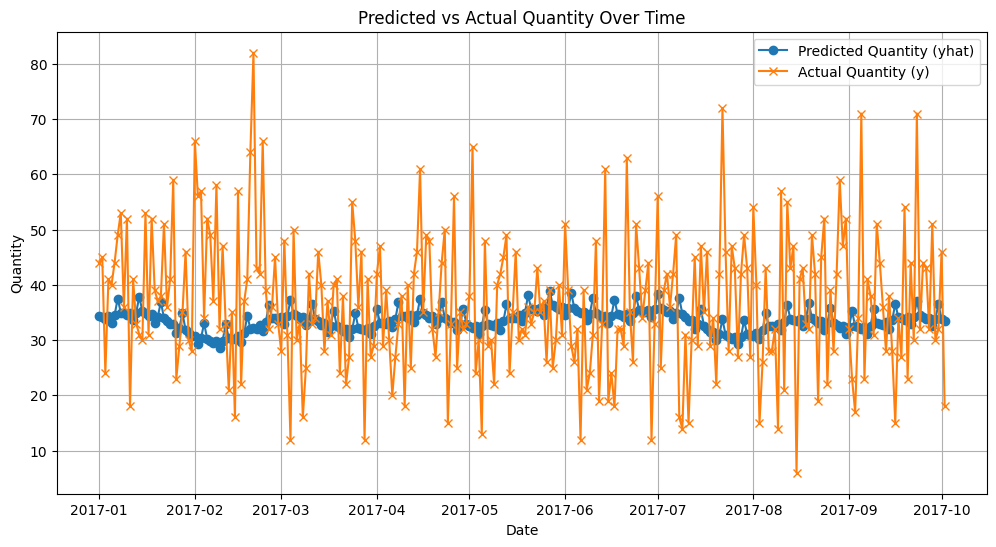

In [172]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(results['ds'], results['yhat'], label='Predicted Quantity (yhat)', marker='o')
plt.plot(results['ds'], results['y'], label='Actual Quantity (y)', marker='x')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Predicted vs Actual Quantity Over Time')
plt.legend()

# Show plot
plt.grid(True)
plt.show()

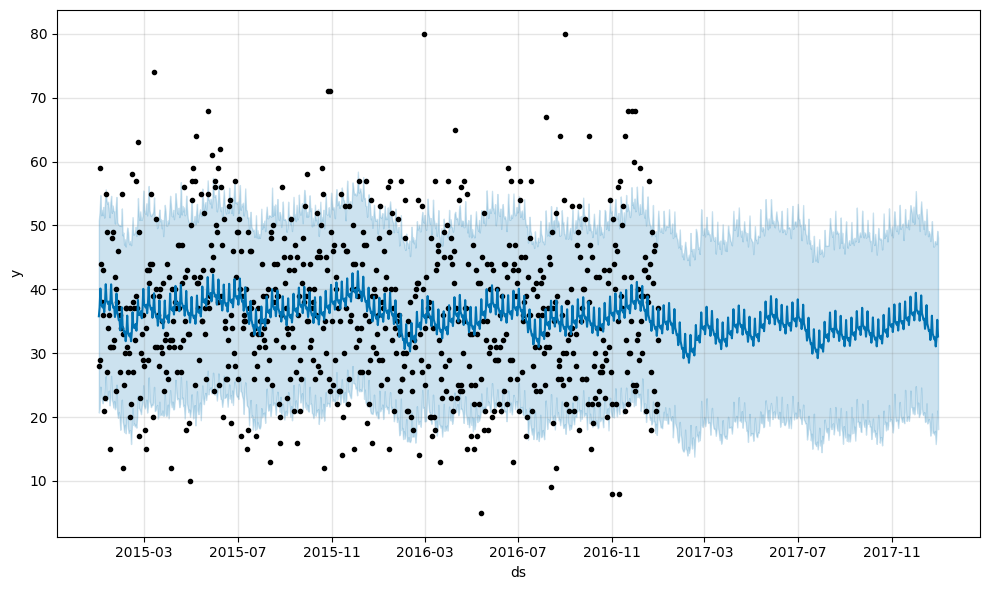

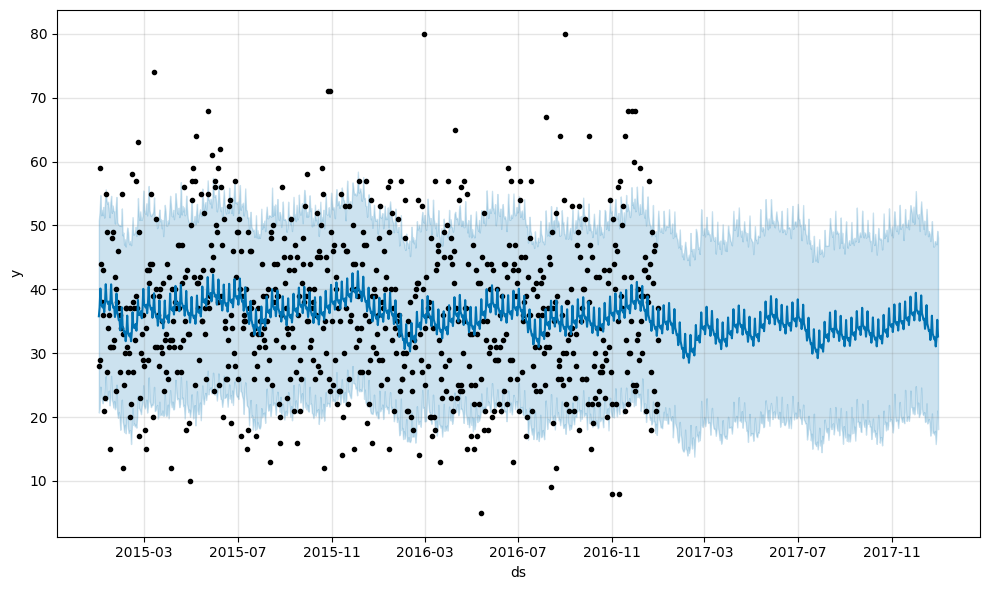

In [60]:
import warnings

# Ignore the specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

# Plot the forecast
prophet.plot(forecast)

## Exponential Smoothing

In [63]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [94]:
actual_expo = spark.sql('select * from actual')
actual_expo = actual_expo.toPandas()
actual_expo

,ds,y
0,2017-01-01,44
1,2017-01-02,45
2,2017-01-03,24
3,2017-01-04,41
4,2017-01-05,40
...,...,...
270,2017-09-28,51
271,2017-09-29,30
272,2017-09-30,32
273,2017-10-01,46


In [115]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Create DataFrame
# df = pd.DataFrame(data)
df = prophet_df

# Set ds as the index
# df.set_index('ds', inplace=True)

# Fit the model
model = ExponentialSmoothing(df['y'], trend='add', seasonal=None, seasonal_periods=None)
fit = model.fit()

# Make predictions
df['yhat'] = fit.fittedvalues

# Forecast future values (e.g., for the next 5 periods)
forecast_steps = 5
forecast = fit.forecast(steps=forecast_steps)

# Create a DataFrame for the forecasted values
forecast_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='M')
forecast_df = pd.DataFrame({
    'ds': forecast_dates,
    'yhat': forecast
})

# Reset index for concatenation
df = df.reset_index()

# Combine actual, fitted, and forecast values for plotting
combined_df = pd.concat([df, forecast_df], ignore_index=True)

/Users/sunith/opt/anaconda3/envs/dss/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [121]:
spark_df_expo = spark.createDataFrame(combined_df)
spark_df_expo.createOrReplaceTempView("expo_pred")


In [135]:
spark.sql("""
          CREATE OR REPLACE TEMPORARY VIEW pred_expo AS
          select DATE_FORMAT(CAST(ds AS DATE), 'yyyy-MM-dd') AS ds,
          yhat 
          from expo_pred
          """)

DataFrame[]

In [139]:
expo_results = spark.sql("""
          select p.ds, a.y, p.yhat
          from pred_expo as p
          inner join actual as a on a.ds = p.ds
          """).toPandas()

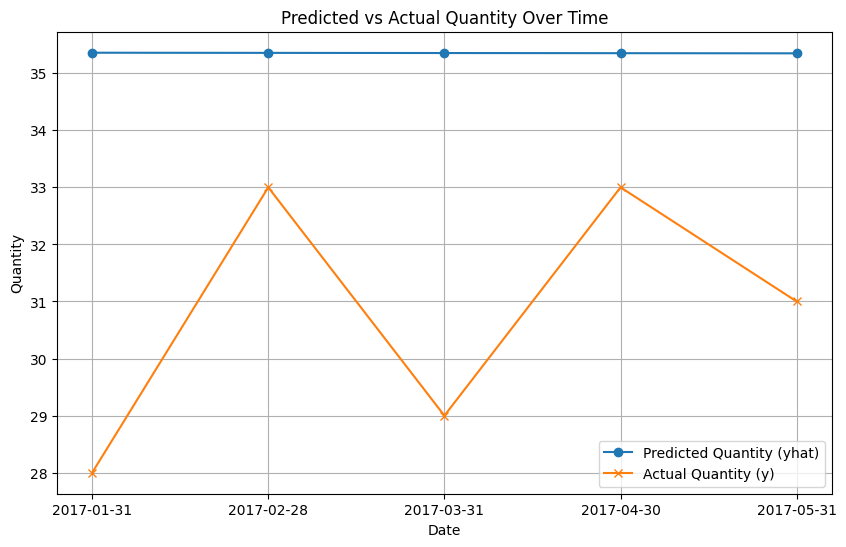

In [140]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(expo_results['ds'], expo_results['yhat'], label='Predicted Quantity (yhat)', marker='o')
plt.plot(expo_results['ds'], expo_results['y'], label='Actual Quantity (y)', marker='x')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Predicted vs Actual Quantity Over Time')
plt.legend()

# Show plot
plt.grid(True)
plt.show()